# Denoising handwritten digits using autoencoders

- This is a spinoff from the handwritten digit recognition project. Artificial noise (gaussian) is added to images and the autoencoder will attempt to reconstruct the original image.

Source of code : https://github.com/iitkliv/dlvcnptel/blob/master/lecture12.ipynb

---

## Importing libraries and dataset

In [1]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from tqdm import tqdm

print(torch.__version__)

1.7.0


In [2]:
# Downloading MNIST dataset
download = datasets.MNIST("../downloads/MNIST/", train=True, download=True)

In [3]:
# Path for storing data
Datapath = "../downloads/MNIST/MNIST/raw/"

## Defining basic functions needed

In [4]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [5]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [6]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [7]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [8]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))

In [9]:
print("Train images size : " + str(TrainImages.size()))
print("Test images size  : " + str(TrainImages.size()))

Train images size : torch.Size([60000, 784])
Test images size  : torch.Size([60000, 784])


In [10]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


In [11]:
def add_noise(image, std_dev, dev=device):
    noise = torch.abs(std_dev * torch.randn(*image.shape).to(dev))
    return image + noise

In [12]:
def model_init(m):
    if(isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [13]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().cpu()
    return hook

## Defining the autoencoder

In [14]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1, 3, 3, stride=1, padding=1), nn.ReLU())
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(3,10, 3, stride=1, padding=1), nn.ReLU())
        self.encoder_pool = nn.MaxPool2d(2, stride=2)
        

        self.decoder_conv1 = nn.Sequential(nn.Conv2d(10,3, 3, stride=1, padding=1), nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.Conv2d(3, 3, 3, stride=1, padding=1), nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.Conv2d(3, 1, 3, stride=1, padding=1), nn.ReLU())
        self.decoder_upsample = nn.Upsample(scale_factor=2)

        self.encoder = nn.Sequential(self.encoder_conv1, self.encoder_pool, self.encoder_conv2, self.encoder_pool)
        self.decoder = nn.Sequential(self.decoder_conv1, self.decoder_upsample, self.decoder_conv2, self.decoder_upsample, self.decoder_conv3)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
net = autoencoder()
print(net)

net = net.double().to(device)

net.encoder.register_forward_hook(get_activation("encoder"))

autoencoder(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (encoder_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_conv1): Sequential(
    (0): Conv2d(10, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_upsample): Upsample(scale_factor=2.0, mode=nearest)
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

## Defining optimizer

In [15]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

## Training the autoencoder

In [16]:
net.apply(model_init)
first = True

100%|██████████| 40/40 [12:18<00:00, 18.46s/it] Iteration :  40/ 40; loss : 0.009
Finished training



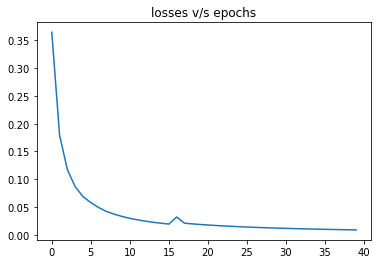

In [19]:
iterations = 40
BatchSize = 5000
noise = 100

# Set this to true to view the input, noised input, and output of the autoencoder for each epoch
debug = False

losses = []
for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages, 0, torch.linspace(i*BatchSize, (i+1)*BatchSize-1, steps=BatchSize).long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        inputs = inputs.view(-1,1,28,28)

        # Doesnt apply noise for first few epochs, to make learning easier
        if(first):
            noised = inputs
        else:
            noised = add_noise(inputs, noise/255)

        optimizer.zero_grad()
        outputs = net(noised)

        loss = criterion(outputs, inputs)
        loss.backward()
        
        optimizer.step()
        runningLoss += loss.item()

        if(debug and i==0):
            plt.subplot(141)
            plt.title("Original input")
            plt.imshow(inputs[0].view(28,28).cpu(), cmap="gray")
            plt.subplot(142)
            plt.title("Noised input")
            plt.imshow(noised[0].view(28,28).cpu(), cmap="gray")
            plt.subplot(143)
            plt.title("Decoder output")
            plt.imshow(outputs[0].view(28,28).cpu().detach(), cmap="gray")
            plt.subplot(144)
            plt.title("Encoder output")
            plt.imshow(activation["encoder"][0,0], cmap="gray")
            plt.show()
    
    loss = runningLoss/(epoch+1)
    losses.append(loss)
    if(epoch%10==9):
        print(" Iteration : %3d/%3d; loss : %2.3f"%(epoch+1, iterations, loss))
    
    if(epoch == 15):
        first = False
        # Learning rate has to be reduced when noise is added. Else, it causes parameters to explode
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

plt.plot(losses)
plt.title("losses v/s epochs")

print("Finished training")

## Visualising result


Test set index number : 9587


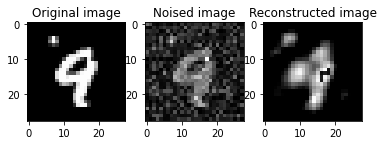


Test set index number : 4439


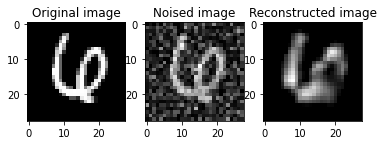


Test set index number : 321


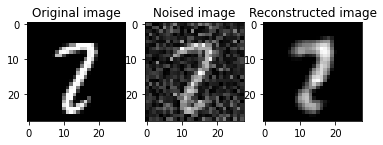


Test set index number : 7474


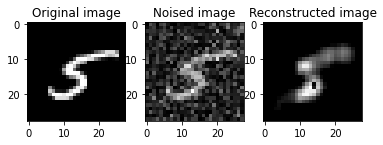


Test set index number : 7221


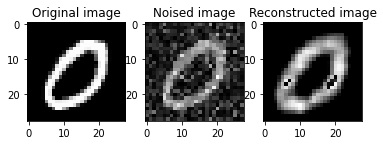


Test set index number : 9499


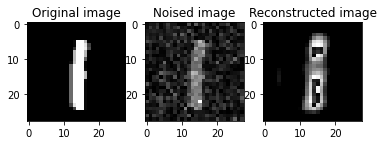


Test set index number : 4051


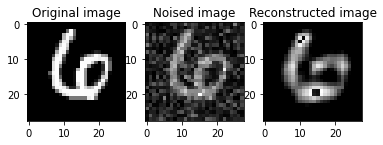


Test set index number : 9053


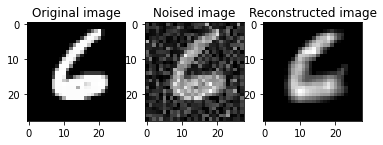


Test set index number : 3355


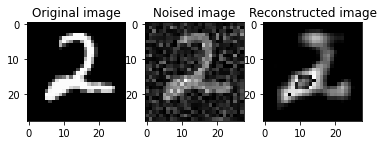


Test set index number : 3358


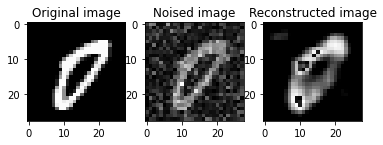

In [20]:
indices = np.random.uniform(0, TestImages.shape[0], size=10)

for i in indices:
    print()
    print("Test set index number : %d"%i)

    test_img = TestImages[int(i)].view(-1,1,28,28)

    test_noise = 100
    noised_img = add_noise(test_img, test_noise, "cpu")

    out = net((noised_img.double().to(device))/255)
    output_img = (out.data*255).byte()
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output_img = output_img.cpu()
        noised_img = noised_img.cpu()

    test_img = test_img.view(-1, 28, 28)
    noised_img = noised_img.view(-1, 28, 28)

    plt.subplot(1,3,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Original image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,3,2)
    img = np.array(noised_img.numpy())[0]
    plt.title("Noised image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,3,3)
    out_img = np.array(output_img.numpy())[0]
    plt.title("Reconstructed image")
    plt.imshow(out_img, cmap="gray")

    plt.show()